In [1]:
import os
import cv2
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt

from glob import glob
from skimage import io
from open3d.web_visualizer import draw

[Warning] Since Open3D 0.15, installing Open3D via conda is deprecated. Please re-install Open3D via: `pip install open3d -U`.
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Resetting default logger to print to terminal.


## This notebook previews the generated raw data and helps to debug or visualize results.

In [8]:
USER_HOME = os.path.expanduser("~")
CESIUM_DEFAULT = os.path.join(USER_HOME, 'Documents/Cesium')  # this path is true in Linux, please modify according to your need.
DATA_DIR = os.path.join(CESIUM_DEFAULT, 'demo-LHS')
OUT_DIR = os.path.abspath(os.path.join(DATA_DIR, '..', os.path.basename(DATA_DIR)+'-preview'))
os.makedirs(OUT_DIR, exist_ok=True)

print(DATA_DIR)
print(OUT_DIR)

/home/regislongchamp/Documents/Cesium/demo-LHS
/home/regislongchamp/Documents/Cesium/demo-LHS-preview


In [3]:
def raw_data_sanity_check(data_dir):
    """Sanity check for the raw data"""
    img_ls = sorted(glob(os.path.join(data_dir, '*_img.png')))
    pc_ls = sorted(glob(os.path.join(data_dir, '*_pc.npy')))
    sm_ls = sorted(glob(os.path.join(data_dir, '*_semantics.npy')))
    cam_pose = glob(os.path.join(data_dir, '*_poses.npy'))
    assert len(cam_pose) == 1, "Camera pose .npy is not found or is not unique!"
    cam_pose = np.load(cam_pose[0])
    
    # data size check
    assert len(pc_ls) == len(img_ls), "Camera pose list length is {:d}, but {:d} images data are found.".format(len(cam_pose), len(img_ls))
    assert len(pc_ls) == len(cam_pose), "Camera pose list length is {:d}, but {:d} point clouds data are found.".format(len(cam_pose), len(pc_ls))
    print("{:d} data points are found...".format(len(cam_pose)))
    if len(sm_ls) != len(cam_pose):
        print("Warning: {:d} semantics maps are found but the camera pose list length is {:d}!".format(len(sm_ls), len(cam_pose)))
        sm_ls = sm_ls + [None] * (len(cam_pose) - len(sm_ls))
        
    return cam_pose, img_ls, pc_ls, sm_ls
    
def plot_data(pose, img, pc, sm, draw_in_place=False):
    """
    Plot a single data point.
    @param pose: 6D camera pose, XYZ + yaw-pitch-roll
    @param img: image array [H, W, 3]
    @param pc: scene coordinate [H, W, 3]
    @param sm: semantics label [H, W]
    """
    
    if img.shape[-1] == 4:
        img = img[:, :, :3]
        
    if draw_in_place:
        print("Open3d point cloud visualization is enabled only for the first data point")
        points = pc[pc!=-1].reshape(-1, 3)
        colors = img[pc!=-1].reshape(-1, 3)

        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(points)
        pcd.colors = o3d.utility.Vector3dVector(colors / 255)
        # o3d.visualization.draw_geometries([pcd])
        draw([pcd]);
    else:         
        # init        
        pc_raw = pc.copy()
        pc_flat = pc.reshape(-1, 3)
        mask_valid = pc_flat[:, 0] != -1
        pc_shape = pc.shape
        
        # depth
        depth = np.linalg.norm(pc - pose[None, None, :3], 2, axis=-1)
        depth[pc[:,:,0] == -1] = -1
        
        # surafce normal
        coords = pc_flat.copy()
        coords = coords[mask_valid]
        
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(coords)
        pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamKNN(knn=16))
        pcd.normalize_normals()
        o3d.geometry.PointCloud.orient_normals_towards_camera_location(pcd, pose[:3])

        normals = pc.reshape(-1, 3).clip(min=0).astype(np.uint8)  # [N, 3]
        normals[mask_valid] = ((np.asarray(pcd.normals) + 1.0) / 2.0 * 255).astype(np.uint8)  # [X, 3]
        normals = normals.reshape(pc_shape)  # [H, W, 3]
        
        # orb keypoints
        orb = cv2.ORB_create(512)
        keypoint, des = orb.detectAndCompute(img, None)
        img_orb = cv2.drawKeypoints(img, keypoint, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
                
        # normalize point cloud value
        pc = pc_flat[mask_valid]
        pc -= np.mean(pc, axis=0)
        pc = (pc - np.min(pc, axis=0)) / (np.max(pc, axis=0) - np.min(pc, axis=0))
        
        pc_all = pc_flat.copy()
        pc_all[mask_valid] = pc
        pc_all[np.logical_not(mask_valid)] *= 0
        pc = pc_all.reshape(pc_shape)
        pc = (pc * 255).astype(np.uint8)
        
        # plot
        fig, axes = plt.subplots(2, 3, figsize=(18, 9))
        plt.subplots_adjust(hspace=0.5)
        for row in range(2):
            for col in range(3):
                axes[row, col].axis('off')
                
        axes[0, 0].imshow(img)
        axes[0, 0].set_title("Synthetic RGB image", fontsize=20)
        
        axes[0, 1].imshow(pc)
        axes[0, 1].set_title("Scene coordiantes (XYZ per pixel)\n *Visualization may be vague.", fontsize=20)
        
        axes[0, 2].imshow(sm)
        axes[0, 2].set_title("Semantics map \n *Visualization may be vague.", fontsize=20)
        
        axes[1, 0].imshow(depth)
        axes[1, 0].set_title("Euclidean depth \n *Visualization may be vague.", fontsize=20)

        axes[1, 1].imshow(normals)
        axes[1, 1].set_title("Surface normals \n *Visualization may be vague.", fontsize=20)
        
        axes[1, 2].imshow(img_orb)
        axes[1, 2].set_title("ORB keypoints \n *Visualization may be vague.", fontsize=20)
        
        axes[0, 0].text(0.1, 0.97, 'Raw data generated by our workflow, e.g., RGB, scene coord, semantics and pose (omitted).', 
                color='blue', fontsize=24, transform=plt.gcf().transFigure)

        axes[1, 0].text(0.1, 0.51, 'Some additional data created using raw data, e.g., depth, surface normals and 2D keypoints.', 
                color='orange', fontsize=24, transform=plt.gcf().transFigure)
        
        plt.savefig(os.path.join(OUT_DIR, 'preview.png'), dpi=100, bbox_inches='tight')
        

In [9]:
cam_pose, img_ls, pc_ls, sm_ls = raw_data_sanity_check(DATA_DIR)
plot_data(cam_pose[0], io.imread(img_ls[0]), np.load(pc_ls[0]), np.load(sm_ls[0]), True)  # interactive point cloud visualization

3 data points are found...
Open3d point cloud visualization is enabled only for the first data point
[Open3D INFO] Window window_0 created.
[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x7f79f121f010 (threading is enabled)
[Open3D INFO] ICE servers: {"stun:stun.l.google.com:19302", "turn:user:password@34.69.27.100:3478", "turn:user:password@34.69.27.100:3478?transport=tcp"}
[Open3D INFO] Set WEBRTC_STUN_SERVER environment variable add a customized WebRTC STUN server.
[Open3D INFO] WebRTC Jupyter handshake mode enabled.


../src/intel/isl/isl.c:2220: FINISHME: ../src/intel/isl/isl.c:isl_surf_supports_ccs: CCS for 3D textures is disabled, but a workaround is available.


WebVisualizer(window_uid='window_0')

EGL(1.5)
OpenGL(4.6)
[Open3D INFO] [Called HTTP API (custom handshake)] /api/getIceServers
[Open3D INFO] [Called HTTP API (custom handshake)] /api/call
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/getIceCandidate
[Open3D INFO] DataChannelObserver::OnStateChange label: 

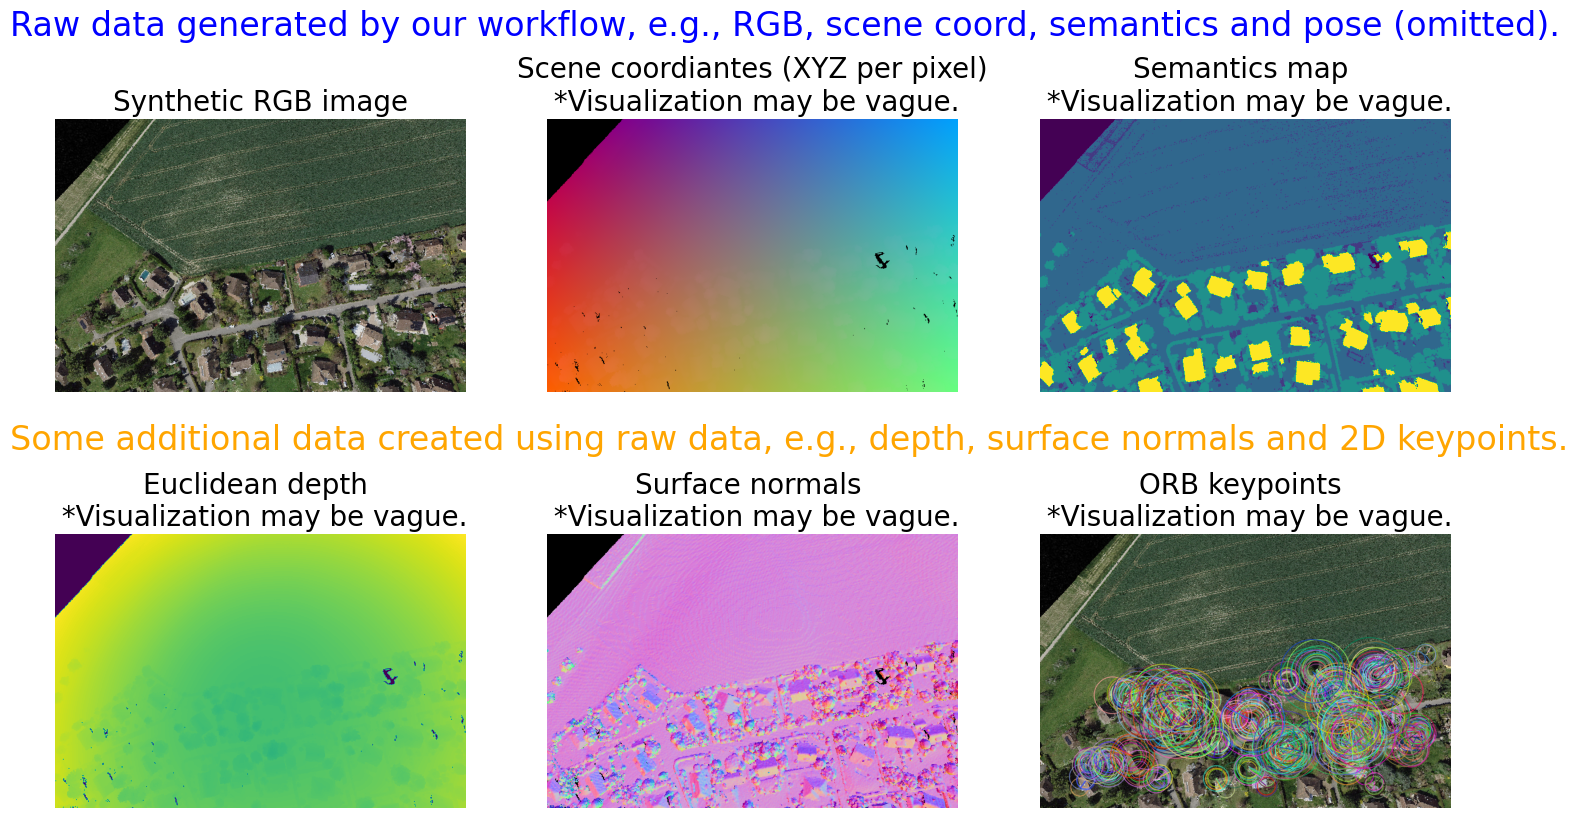

[000:000][11377] (stun_port.cc:96): Binding request timed out from 192.168.1.x:50102 (wlp0s20f3)


In [10]:
for i, (pose, img, pc, sm) in enumerate(zip(cam_pose, img_ls, pc_ls, sm_ls)):
    if i == 1:
        break
    img = io.imread(img)
    pc = np.load(pc)
    sm = np.load(sm)
    plot_data(pose, img, pc, sm)